# The Kalman Filter
The Kalman filter is a recursive state-estimation algorithm for linear dynamical systems subject to process and measurement noise. It provides the minimum-variance unbiased estimate of the system state under the assumptions of linear dynamics and Gaussian noise

A single iteration of the Kalman filter algorithm is decomposed into two operations:

- **Predict** (Time Update).
The filter uses the system dynamics to propagate the current state estimate and its associated covariance forward in time. This step predicts what the state should be prior to receiving any new measurements.

- **Update** (Measurement Update).
When a measurement becomes available, the filter incorporates it to correct the prediction. The correction balances trust in the model (the prediction) against trust in the measurement, with the Kalman gain providing the optimal weighting.

## Linear Gaussian System Model

The filter is derived for the standard linear discrete-time system:

\begin{array}{rlr}
x_{k+1} & =F_k x_k+w_k, & w_k \sim \mathcal{N}\left(0, Q_k\right), \\
y_k & =H_k x_k+v_k, & v_k  \sim \mathcal{N}\left(0, R_k\right), \\
\end{array}

where
- $x_k \in \mathbb{R}^n$ is the state,
- $y_k \in \mathbb{R}^m$ is the measurement,
- $F_k$ is the state transition matrix,
- $H_k$ is the measurement matrix,
- $Q_k$ and $R_k$ are the process- and measurement-noise covariances.

The Kalman filter maintains the pair $\left(\hat{x}_{k \mid k}, P_{k \mid k}\right)$, where $\hat{x}_{k \mid k}$ is the estimated state at time $k$ and $P_{k \mid k}$ its covariance.


### Predict
The filter uses the system dynamics to propagate the estimate and covariance:
$$\begin{array}{rcl}
\hat{x}_{k+1|k} &=& F_k\,\hat{x}_{k|k}, \\[6pt]
P_{k+1|k} &=& F_k\,P_{k|k}\,F_k^{\top} + Q_k .
\end{array}$$
This predicts where the system should be before incorporating any measurements.

### Update 
When a new measurement $y_{k+1}$ becomes available, the filter incorporates it:

$$
\begin{gathered}
K_{k+1}=P_{k+1 \mid k} H_{k+1}^{\top}\left(H_{k+1} P_{k+1 \mid k} H_{k+1}^{\top}+R_{k+1}\right)^{-1}, \\
\hat{x}_{k+1 \mid k+1}=\hat{x}_{k+1 \mid k}+K_{k+1}\left(y_{k+1}-H_{k+1} \hat{x}_{k+1 \mid k}\right), \\
P_{k+1 \mid k+1}=\left(I-K_{k+1} H_{k+1}\right) P_{k+1 \mid k} .
\end{gathered}
$$


The term

$$
y_{k+1}-H_{k+1} \hat{x}_{k+1 \mid k}
$$

is the **innovation**, capturing the discrepancy between the prediction and the measurement.

## The Kalman Filter as a Dynamical System

The evolution function encodes the full predict-and-update procedure:

$$
x_{k+1}^{\mathrm{KF}}=f_{\mathrm{KF}}\left(x_k^{\mathrm{KF}}, u_{k+1}\right) .
$$


The output function returns the current state estimate:

$$
y_k^{\mathrm{KF}}=h_{\mathrm{KF}}\left(x_k^{\mathrm{KF}}\right)=\hat{x}_{k \mid k} .
$$

Under this viewpoint, the state of the Kalman filter is:

$$
x_k^{\mathrm{KF}}=\left(\hat{x}_{k \mid k}, P_{k \mid k}\right),
$$

and the input contains the plant measurement and model parameters:

$$
u_k=\left(y_k, F_k, H_k, Q_k, R_k\right) .
$$

### Software Implementation
We implement a `KF` class with static methods `f` and `h`. The method `f` plays the role of the evolution function: it takes the current filter state $(\hat{x}, P)$,
together with the current measurement and model objects $(f, F, Q, h, H, R)$ and
their parameter dictionaries, and returns the updated pair $(\hat{x}^+, P^+)$.
The method `h` is the output function: it extracts the current state estimate
$\hat{x}$ from the internal filter state.


In [44]:
import numpy as np
from numpy.typing import NDArray
from typing import Callable, Dict, Tuple 
class NaiveKF:
    @staticmethod
    def f(
        *
        xhat_P: Tuple[NDArray, NDArray],  # [x̂, P]
        yk: NDArray,
        f: Callable,
        f_params: Dict,
        F: Callable,
        F_params: Dict,            
        Q: Callable,
        Q_params: Dict,
        h: Callable,
        h_params: Dict,            
        H: Callable,
        H_params: Dict,                        
        R: Callable,
        R_params: Dict,                                    
    ) -> Tuple[NDArray, NDArray]:

        # extract state variables
        _, Pk = xhat_P

        # predict
        x_pred = f(**f_params)        
        Fk = F(**F_params)
        Qk = Q(**Q_params)
        P_pred = Fk @ Pk @ Fk.T + Qk        

        # innovation
        y_pred = h(**h_params)
        innovation = yk - y_pred                       # (m,1)

        # update
        Hk = H(**H_params)
        Rk = R(**R_params)
        Sk = Hk @ P_pred @ Hk.T + Rk                       # (m,m)
        ridge = 1e-9 * np.eye(Sk.shape[0])
        try:
            Sk_inv = np.linalg.inv(Sk + ridge)
        except np.linalg.LinAlgError:
            Sk_inv = np.linalg.pinv(Sk + ridge)

        Kk = P_pred @ Hk.T @ Sk_inv                        # (n,m)        
        x_upd = x_pred + Kk @ innovation                   # (n,1)
        I = np.eye(P_pred.shape[0])
        P_upd = (I - Kk @ Hk) @ P_pred @ (I - Kk @ Hk).T + Kk @ Rk @ Kk.T
        P_upd = 0.5 * (P_upd + P_upd.T)                    # symmetrize

        return (x_upd, P_upd)
    
    @staticmethod
    def h(xhat_P: Tuple[NDArray, NDArray]) -> NDArray:
        return xhat_P[0]

### Example Simulation

#### Damped Harmonic Oscillator (2-state system)
We model the system

$$
\begin{aligned}
& \dot{x}=v, \\
& \dot{v}=-2 \zeta \omega_0 v-\omega_0^2 x .
\end{aligned}
$$

State vector:

$$
\mathbf{x}=\left[\begin{array}{l}
x \\
v
\end{array}\right]
$$

To convert the continuous-time damped harmonic oscillator into an evolution function, we introduce a sampling time Δ𝑡>0 and form a discrete-time approximation.

Using explicit Euler with step $\Delta t$,

$$
\begin{aligned}
& x_{k+1}=x_k+\Delta t v_k, \\
& v_{k+1}=v_k+\Delta t\left(-2 \zeta \omega_0 v_k-\omega_0^2 x_k\right) .
\end{aligned}
$$


In vector form:

$$
\mathbf{x}_{k+1}=f_{\Delta}\left(\mathbf{x}_k\right)=\left[\begin{array}{c}
x_k+\Delta t v_k \\
v_k+\Delta t\left(-2 \zeta \omega_0 v_k-\omega_0^2 x_k\right)
\end{array}\right] .
$$

A standard measurement model outputs only the position:

$$
y=x .
$$

##### Define DHO dynamical system object

In [22]:
import pykal 
omega0 = 1.0   # natural frequency
zeta = 0.1     # damping ratio

def f_oscillator(pos_vel: NDArray, *, dt: float) -> NDArray:
    """
    Discrete-time evolution function for the damped harmonic oscillator.
    State pos_vel is a 2x1 column vector: [position; velocity].

    x_{k+1} = f_oscillator(x_k, dt=...)
    """
    # ensure column vector
    x = np.asarray(pos_vel, dtype=float).reshape(2, 1)
    pos = float(x[0, 0])
    vel = float(x[1, 0])

    pos_next = pos + dt * vel
    vel_next = vel + dt * (-2.0 * zeta * omega0 * vel - (omega0**2) * pos)

    x_next = np.array([[pos_next], [vel_next]], dtype=float)
    return x_next

def h_oscillator(pos_vel: NDArray) -> NDArray:
    """
    Measurement function: y = position.
    Returns a 1x1 column vector.
    """
    x = np.asarray(pos_vel, dtype=float).reshape(2, 1)
    return x[0:1, :]  # or np.array([[x[0, 0]]])


dho = pykal.DynamicalSystem(f=f_oscillator,h=h_oscillator,state_name="pos_vel")

##### Simulate DHO

<Axes: >

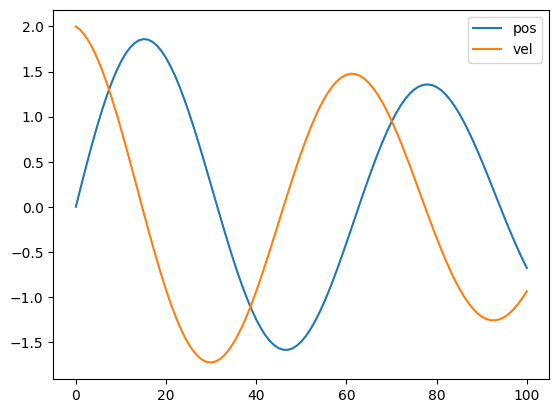

In [23]:
# simulate dynamics 
dt = 0.1
pos_vel = np.asarray([0,2], dtype=float).reshape(2, 1)
pos_vel_hist = [pos_vel]
pos_hist = [pos_vel[0]]
for tk in np.arange(0,10,0.1):
    # state,measurement
    pos_vel,pos = dho.step(param_dict={"pos_vel":pos_vel,"dt":dt},return_state=True)

    pos_vel_hist.append(pos_vel)
    pos_hist.append(pos)

import pandas as pd

pos_vel_DF = pd.DataFrame(np.hstack(pos_vel_hist).T,columns=["pos","vel"])
pos_vel_DF.plot()

##### Compute Jacobians for Kalman Filter

Given the discrete-time evolution

$$
\begin{aligned}
& x_{k+1}=x_k+\Delta t v_k \\
& v_{k+1}=v_k+\Delta t\left(-2 \zeta \omega_0 v_k-\omega_0^2 x_k\right),
\end{aligned}
$$

the underlying continuous-time system has Jacobian

$$
A=\frac{\partial \dot{x}}{\partial x}=\left[\begin{array}{cc}
0 & 1 \\
-\omega_0^2 & -2 \zeta \omega_0
\end{array}\right] .
$$


Using explicit Euler, the discrete-time state-transition Jacobian is

$$
F_k=I+\Delta t A=\left[\begin{array}{cc}
1 & \Delta t \\
-\Delta t \omega_0^2 & 1-2 \zeta \omega_0 \Delta t
\end{array}\right] .
$$


The measurement is $y=x$, so

$$
H_k=\left[\begin{array}{ll}
1 & 0
\end{array}\right]
$$

In [29]:
def F_oscillator(pos_vel: NDArray, *, dt: float) -> NDArray:
    """
    Discrete-time state-transition Jacobian for the damped harmonic oscillator,
    using explicit Euler discretization.

    F_k = I + dt * A, where
        A = [[0,            1],
             [-omega0**2,  -2*zeta*omega0]]

    Returns a 2x2 matrix.
    """
    return np.array([
        [1.0,                 dt],
        [-dt * (omega0**2),   1.0 - 2.0 * zeta * omega0 * dt],
    ], dtype=float)

def H_oscillator(pos_vel: NDArray) -> NDArray:
    """
    Measurement Jacobian for y = x.

    Returns a 1x2 matrix.
    """
    return np.array([[1.0, 0.0]], dtype=float)

def Q_oscillator(pos_vel: NDArray) -> NDArray:
    return np.eye(len(pos_vel)) * 0.1

def R_oscillator(pos: NDArray) -> NDArray:
    return np.eye(len(pos)) * 0.1


##### Define KF dynamical system object

In [30]:
kf = pykal.DynamicalSystem(f=KF.f,h=KF.h,state_name="xhat_P")

##### Simulate DHO + KF

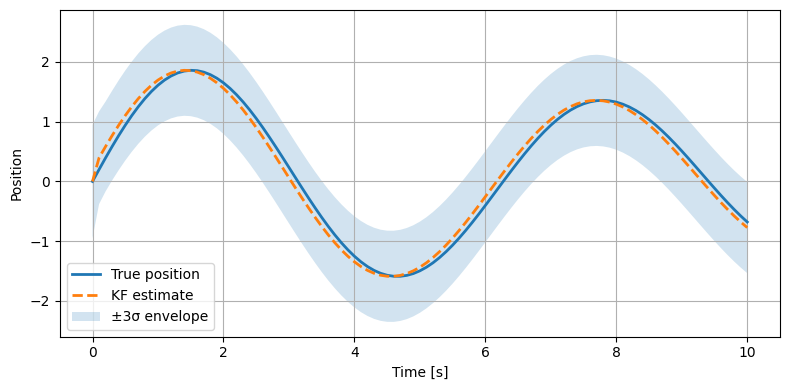

In [39]:
# simulate dynamics 
dt = 0.1
pos_vel = np.asarray([0,2], dtype=float).reshape(2, 1)

pos_vel_hist = [pos_vel]
pos_hist = [pos_vel[0]]

xhat_P = [pos_vel,Q_oscillator(pos_vel)]
xhat_P_hist = [xhat_P]
xhat_hist = [xhat_P[0]]
for tk in np.arange(0,10,0.1):
    # state,measurement
    pos_vel,pos = dho.step(param_dict={"pos_vel":pos_vel,"dt":dt},return_state=True)
    xhat_P, xhat = kf.step(return_state=True,param_dict={"xhat_P":xhat_P,"yk":pos,
                                             "f": f_oscillator,"f_params":{"pos_vel":pos_vel,"dt":dt,},
                                             "h": h_oscillator, "h_params":{"pos_vel": pos_vel},
                                             "F": F_oscillator,"F_params":{"pos_vel":pos_vel,"dt":dt},
                                             "H": H_oscillator,"H_params":{"pos_vel":pos},                                             
                                             "Q": Q_oscillator,"Q_params":{"pos_vel":pos_vel},
                                             "R": R_oscillator,"R_params":{"pos":pos},                                                                                                  
                                             },
                                             )

    pos_vel_hist.append(pos_vel)
    pos_hist.append(pos)
    xhat_P_hist.append(xhat_P)
    xhat_hist.append(xhat)

import pandas as pd
import matplotlib.pyplot as plt

# Extract true position over time
true_pos = np.array([pv[0,0] for pv in pos_vel_hist])

# Extract KF estimated position and covariance P[0,0]
xhat_list = [xp[0] for xp in xhat_P_hist]       # xp = (xhat, P)
Phat_list = [xp[1] for xp in xhat_P_hist]

kf_pos = np.array([xh[0,0] for xh in xhat_list])
kf_sigma = np.sqrt(np.array([P[0,0] for P in Phat_list]))

upper_3sigma = kf_pos + 3*kf_sigma
lower_3sigma = kf_pos - 3*kf_sigma

t = np.arange(len(true_pos)) * dt

# ---- Plotting ----
plt.figure(figsize=(8,4))

plt.plot(t, true_pos, label="True position", linewidth=2)
plt.plot(t, kf_pos, '--', label="KF estimate", linewidth=2)

plt.fill_between(t, lower_3sigma, upper_3sigma,
                 alpha=0.2, label="±3σ envelope")

plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
import numpy as np
from numpy.typing import NDArray
from typing import Callable, Dict, Tuple

class KF:
    """
    Square-root Kalman filter in the spirit of Ramos (2021), using:

      - Square-root *time update* via QR:
            P_{k+1|k} = F_k P_{k|k} F_k^T + Q_k
        with P represented as S S^T and updated via a stacked QR.

      - Square-root *measurement update*:
        Joseph-form covariance update followed by a Cholesky factorization.

    The filter state is (x_hat, S), where S is a lower-triangular factor
    such that P = S S^T.
    """

    @staticmethod
    def f(
        *,
        xhat_P: Tuple[NDArray, NDArray],  # (x̂_k, S_k)
        yk: NDArray,
        f: Callable,
        f_params: Dict,
        F: Callable,
        F_params: Dict,
        Q: Callable,
        Q_params: Dict,
        h: Callable,
        h_params: Dict,
        H: Callable,
        H_params: Dict,
        R: Callable,
        R_params: Dict,
    ) -> Tuple[NDArray, NDArray]:
        """
        One full EKF step (predict + update) with square-root covariance.

        xhat_P = (x̂_k, S_k), where S_k is a Cholesky factor of P_k.
        """

        xk, Sk = xhat_P
        xk = np.asarray(xk, dtype=float).reshape(-1, 1)
        Sk = np.asarray(Sk, dtype=float)

        n = xk.shape[0]
        eps = 1e-9

        # --------------------- Time update ---------------------
        # State prediction
        x_pred = np.asarray(f(**f_params), dtype=float).reshape(n, 1)

        Fk = np.asarray(F(**F_params), dtype=float)
        Qk = np.asarray(Q(**Q_params), dtype=float)

        # Cholesky of Qk (with small ridge if needed)
        try:
            SQ = np.linalg.cholesky(Qk)
        except np.linalg.LinAlgError:
            SQ = np.linalg.cholesky(Qk + eps * np.eye(Qk.shape[0]))

        # Stack S_k F_k^T and SQ, then QR to get S_{k+1|k}
        A = np.vstack((Sk @ Fk.T, SQ))   # shape (2n, n)
        _, R_mat = np.linalg.qr(A, mode="reduced")  # R: (n, n), upper-triangular

        S_pred = R_mat.T  # lower-triangular square root of P_pred

        # --------------------- Measurement update ---------------------
        yk = np.asarray(yk, dtype=float).reshape(-1, 1)
        y_pred = np.asarray(h(**h_params), dtype=float).reshape(-1, 1)
        innovation = yk - y_pred   # (m,1)

        Hk = np.asarray(H(**H_params), dtype=float)
        Rk = np.asarray(R(**R_params), dtype=float)

        # Innovation covariance S_y = H P_pred H^T + R,
        # but compute P_pred from S_pred, then factor.
        P_pred = S_pred @ S_pred.T

        S_y = Hk @ P_pred @ Hk.T + Rk
        m = S_y.shape[0]

        try:
            S_Sy = np.linalg.cholesky(S_y + eps * np.eye(m))
        except np.linalg.LinAlgError:
            S_Sy = np.linalg.cholesky(S_y + 10 * eps * np.eye(m))

        # K = P_pred H^T S_y^{-1}
        # Use Cholesky solves for numerical stability.
        B = Hk @ P_pred         # (m, n)
        # Solve S_Sy^T X = B   ⇒  X = S_Sy^{-T} B = S_y^{-T} B
        X = np.linalg.solve(S_Sy.T, B)   # (m, n)
        Kk = X.T                 # (n, m) = P_pred H^T S_y^{-T}

        # State update
        x_upd = x_pred + Kk @ innovation

        # Covariance update (Joseph form)
        I = np.eye(n)
        P_upd = (I - Kk @ Hk) @ P_pred @ (I - Kk @ Hk).T + Kk @ Rk @ Kk.T
        # Symmetrize to kill round-off asymmetry
        P_upd = 0.5 * (P_upd + P_upd.T)

        # Re-factor P_upd as S_upd S_upd^T
        try:
            S_upd = np.linalg.cholesky(P_upd + eps * np.eye(n))
        except np.linalg.LinAlgError:
            # Fallback with slightly larger ridge if ill-conditioned
            S_upd = np.linalg.cholesky(P_upd + 10 * eps * np.eye(n))

        return (x_upd, S_upd)

    @staticmethod
    def h(xhat_P: Tuple[NDArray, NDArray]) -> NDArray:
        """
        Extract the current state estimate x̂_k from (x̂_k, S_k).
        """
        return np.asarray(xhat_P[0], dtype=float)


In [41]:
kf = pykal.DynamicalSystem(f=KF.f, h=KF.h, state_name="xhat_P")


In [42]:
# simulate dynamics 
dt = 0.1
pos_vel = np.asarray([0,2], dtype=float).reshape(2, 1)

pos_vel_hist = [pos_vel]
pos_hist = [pos_vel[0]]

P0 = Q_oscillator(pos_vel)  # or your chosen initial covariance
S0 = np.linalg.cholesky(P0)
xhat_P = [pos_vel, S0]
xhat_P_hist = [xhat_P]
xhat_hist = [xhat_P[0]]
for tk in np.arange(0,10,0.1):
    # state,measurement
    pos_vel,pos = dho.step(param_dict={"pos_vel":pos_vel,"dt":dt},return_state=True)
    xhat_P, xhat = kf.step(return_state=True,param_dict={"xhat_P":xhat_P,"yk":pos,
                                             "f": f_oscillator,"f_params":{"pos_vel":pos_vel,"dt":dt,},
                                             "h": h_oscillator, "h_params":{"pos_vel": pos_vel},
                                             "F": F_oscillator,"F_params":{"pos_vel":pos_vel,"dt":dt},
                                             "H": H_oscillator,"H_params":{"pos_vel":pos},                                             
                                             "Q": Q_oscillator,"Q_params":{"pos_vel":pos_vel},
                                             "R": R_oscillator,"R_params":{"pos":pos},                                                                                                  
                                             },
                                             )

    pos_vel_hist.append(pos_vel)
    pos_hist.append(pos)
    xhat_P_hist.append(xhat_P)
    xhat_hist.append(xhat)

/tmp/ipykernel_133358/4126013392.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_pos = np.array([float(p[0]) for p in pos_hist]).reshape(-1)
/tmp/ipykernel_133358/4126013392.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf_pos = np.array([float(x[0]) for x in xhat_hist]).reshape(-1)


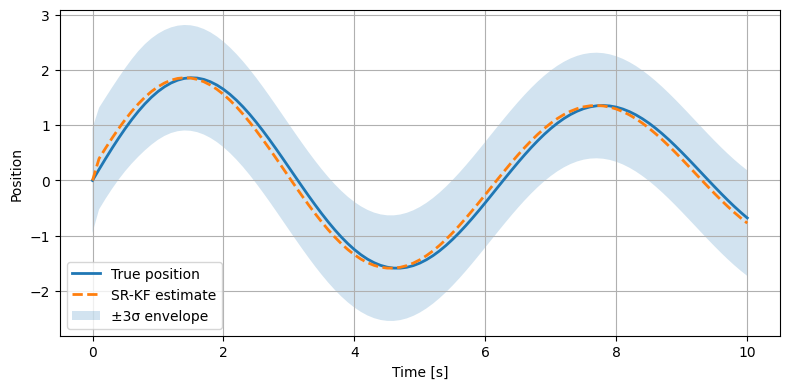

In [43]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(0, 10 + dt, dt)
true_pos = np.array([float(p[0]) for p in pos_hist]).reshape(-1)
kf_pos = np.array([float(x[0]) for x in xhat_hist]).reshape(-1)

# Extract variance of position from S_k
pos_var = []
for xhat_k, S_k in xhat_P_hist:
    # S_k is lower-triangular, P_k = S_k S_k^T
    P_k = S_k @ S_k.T
    pos_var.append(P_k[0, 0])

pos_var = np.array(pos_var)
pos_sigma = np.sqrt(pos_var)
upper_3sigma = kf_pos + 3.0 * pos_sigma
lower_3sigma = kf_pos - 3.0 * pos_sigma

plt.figure(figsize=(8, 4))

plt.plot(t, true_pos, label="True position", linewidth=2)
plt.plot(t, kf_pos, "--", label="SR-KF estimate", linewidth=2)

plt.fill_between(t, lower_3sigma, upper_3sigma,
                 alpha=0.2, label="±3σ envelope")

plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Assume you still have your original covariance-based KF class as KFNaive,
# and the new square-root-based KF as defined above.

kf_naive_block = pykal.DynamicalSystem(f=NaiveKF.f, h=NaiveKF.h, state_name="xhat_P")
kf_sqrt_block  = pykal.DynamicalSystem(f=KF.f,       h=KF.h,       state_name="xhat_P")

dt = 0.1
T_final = 50.0  # longer horizon to exacerbate numerical effects

pos_vel = np.asarray([0, 2], dtype=float).reshape(2, 1)

# Initial covariance
P0 = Q_oscillator(pos_vel) * 10.0  # deliberately moderate/large
S0 = np.linalg.cholesky(P0)

xhat_P_naive = [pos_vel.copy(), P0.copy()]
xhat_P_sqrt  = [pos_vel.copy(), S0.copy()]

xhat_naive = xhat_P_naive[0]
true_hist = []
naive_hist = []
sqrt_hist  = []
naive_sigma = []
sqrt_sigma  = []

for tk in np.arange(0, T_final + dt, dt):
    # True system + measurement
    pos_vel, pos = dho.step(param_dict={"pos_vel": pos_vel, "dt": dt}, return_state=True)

    # Naive KF
    xhat_P_naive, xhat_naive = kf_naive_block.step(
        return_state=True,
        param_dict={
            "xhat_P": xhat_P_naive, "yk": pos,
            "f": f_oscillator, "f_params": {"pos_vel": xhat_naive, "dt": dt},
            "h": h_oscillator, "h_params": {"pos_vel": xhat_naive},
            "F": F_oscillator, "F_params": {"pos_vel": xhat_naive, "dt": dt},
            "H": H_oscillator, "H_params": {"pos_vel": pos},
            "Q": Q_oscillator, "Q_params": {"pos_vel": xhat_naive},
            "R": R_oscillator, "R_params": {"pos": pos},
        },
    )

    # Square-root KF
    xhat_P_sqrt, xhat_sqrt = kf_sqrt_block.step(
        return_state=True,
        param_dict={
            "xhat_P": xhat_P_sqrt, "yk": pos,
            "f": f_oscillator, "f_params": {"pos_vel": xhat_sqrt, "dt": dt},
            "h": h_oscillator, "h_params": {"pos_vel": xhat_sqrt},
            "F": F_oscillator, "F_params": {"pos_vel": xhat_sqrt, "dt": dt},
            "H": H_oscillator, "H_params": {"pos_vel": pos},
            "Q": Q_oscillator, "Q_params": {"pos_vel": xhat_sqrt},
            "R": R_oscillator, "R_params": {"pos": pos},
        },
    )

    # Logging
    true_hist.append(float(pos[0]))
    naive_hist.append(float(xhat_naive[0]))
    sqrt_hist.append(float(xhat_sqrt[0]))

    P_naive = xhat_P_naive[1]
    naive_sigma.append(np.sqrt(P_naive[0, 0]))

    S_sqrt = xhat_P_sqrt[1]
    P_sqrt = S_sqrt @ S_sqrt.T
    sqrt_sigma.append(np.sqrt(P_sqrt[0, 0]))

# Convert to arrays
t = np.arange(0, T_final + dt, dt)
true_hist = np.array(true_hist)
naive_hist = np.array(naive_hist)
sqrt_hist = np.array(sqrt_hist)
naive_sigma = np.array(naive_sigma)
sqrt_sigma = np.array(sqrt_sigma)

plt.figure(figsize=(8, 4))
plt.plot(t, true_hist, label="True position", linewidth=2)
plt.plot(t, naive_hist, "--", label="Naive KF", linewidth=1.5)
plt.plot(t, sqrt_hist, "-.", label="Square-root KF", linewidth=1.5)

plt.fill_between(
    t, naive_hist - 3 * naive_sigma, naive_hist + 3 * naive_sigma,
    alpha=0.15, label="Naive ±3σ"
)
plt.fill_between(
    t, sqrt_hist - 3 * sqrt_sigma, sqrt_hist + 3 * sqrt_sigma,
    alpha=0.15, label="SR-KF ±3σ"
)

plt.xlabel("Time [s]")
plt.ylabel("Position")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: not enough values to unpack (expected 2, got 0)